In [398]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse

from sympy import Symbol, Interval
from sympy.stats import ContinuousRV, sample


In [5]:
"""
Idea is to index a 2D array using some 1D curve. Thus, there is an index mapping from each (x,y)->ind
Further, each site also has an adjancency set. This is the set of indices that are coupled to the site by an FM interaction
The model is defined using a 1xN field matrix and an NxN coupling matrix. The coupling matrix is sparse. N = LxW
"""
L= 3

def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def square_lattice_dictionary(L):
    
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)

            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_lattice_dictionary(L):
    ind_dict = {}
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
            
            #nnn indices
            adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = adjs
    return ind_dict, adj_ind

def triangle_nn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y+1)%L, L), index_map(x,(y-1)%L, L), index_map((x+1)%L,y, L), index_map((x-1)%L,y, L)]
            adjs.append(index_map((x+1)%L,(y-(-1)**(x%2))%L, L))
            adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))

            adj_ind[ind_0] = adjs
    return adj_ind

def triangle_nnn_indices(L):
    adj_ind = {}
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nnn indices
            adjs = [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L), index_map((x+2)%L,y, L), index_map((x-2)%L,y, L)]
            adjs += [index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
            adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)] 
            
            adj_ind[ind_0] = adjs
    return adj_ind

ind_dict, adj_ind = triangle_lattice_dictionary(L)

def linear_fit(x, m, b):
    return m*x + b
def power_law(x, a):
    return x**(-a)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def exponential_dist(x, A, b):
    return A*np.exp(-b*x)

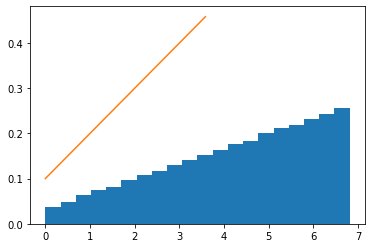

In [3]:
def random_nnDist(a,b,custDist,size=None, nControl=10**6):
    #genearte a list of size random samples, obeying the distribution custDist
    #suggests random samples between x0 and x1 and accepts the suggestion with probability custDist(x)
    #custDist noes not need to be normalized. Add this condition to increase performance. 
    #Best performance for max_{x in [x0,x1]} custDist(x) = 1
    samples=[]
    nLoop=0
    
    low = 0
    high = (np.sqrt(a**2 + 6*b) - a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples

def random_nnnDist(w,a,b,custDist,size=None, nControl=10**6):
    samples=[]
    nLoop=0
    
    low = w
    high = (np.sqrt(a**2 + 2*b*(1+a*w+b*w**2/2))-a)/b
    
    while len(samples)<size and nLoop<nControl:
        x=np.random.uniform(low=low,high=high)
        prop=custDist(x, a, b)
        assert prop>=0 and prop<=1
        if np.random.uniform(low=0,high=1) <=prop:
            samples += [x]
        nLoop+=1
    return samples


#call
a=0.1
b=0.1
def linDist(x, a, b):
    return a + b*x
samples=random_nnDist(a,b,custDist=linDist,size=100000)
#print(samples)

def linDist_nn(x, a, b):
    return (a + b*x)/3.0

plt.hist(np.array(samples), density=True, bins = 20)

x = np.linspace(0, (np.sqrt(a**2 + 2*b) - a)/b, 1000)

plt.plot(x, np.array(linDist(x, a, b)))

In [23]:
def fill_zeta_ij_matrix(size, nn_ind, nnn_ind, a, b, include_nnn=True):
    zeta_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        zeta_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.array(random_nnDist(a, b, custDist=linDist_nn, size=len(upper_ind))))
        
    return zeta_ij_vals + zeta_ij_vals.T

def chunk_deleter(ind_array, size):
    eye_diag = np.ones(size)
    eye_diag[ind_array] = 0
    return sparse.diags(eye_diag)

def resparse(spr_mat, size, tol):
    i_ind, j_ind, vals = sparse.find(spr_mat)
    mask = vals>tol
    i_new, j_new, val_new = i_ind[mask], j_ind[mask], vals[mask]
    
    return sparse.csr_matrix((val_new, (i_new, j_new)), shape=(size, size))


def random_lin_dist_width(a, b, w, n_samples):
    x = Symbol('x')
    X = ContinuousRV(x, (a+b*x)/(a*w + b*w**2/2), Interval(0, w))
    return sample(X, size=(n_samples))


def fill_zeta_ij_matrix_width(size, nn_ind, a, b, w):
    zeta_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        #Filling nn bonds
        adj_ind_array = np.array(nn_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]

        zeta_ij_vals[ind, upper_ind] = sparse.lil_matrix(np.array(random_lin_dist_width(a, b, w, len(upper_ind))))


    return zeta_ij_vals + zeta_ij_vals.T


In [371]:
def update_adjacency_zeta_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j])-set([k]))
        
    return adj_ind

def update_adjacency_beta(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i])-set([k]))
        
    adj_ind[i] = []
    return adj_ind
    
def update_cluster(cluster_dict, reverse_dict,site1, site2):
    #Takes in a dictionary containing the site->cluster mapping, cluster->set of sites mapping, and the two sites being decimated
    #Returns updated dictionaries, containing the new cluster data
    clust1 = cluster_dict[site1]   #cluster of site 1
    clust2 = cluster_dict[site2]   #cluster of site 2

    #Add spins in clust2 to clust1
    for dec_site in reverse_dict[clust2]:
        cluster_dict[dec_site] = clust1

    reverse_dict[clust1] += reverse_dict[clust2]
    reverse_dict[clust2] = None

    return cluster_dict, reverse_dict


In [486]:
class log_system:
    
    def __init__(self, size, adj_ind, zeta_ij_vals, beta_vals):
        
        self.size = size
        self.adj_ind = adj_ind
        self.zeta_ij_vals = zeta_ij_vals
        self.beta_vals = beta_vals
        
        self.Gamma_array = []
        self.Gamma_0 = 0
        self.Gamma = 0
        
        self.clust_dict = {i:i for i in range(size)}
        self.reverse_dict = {i:[i] for i in range(size)}
        
        return None
    
    def decimate(self):
        beta_min, zeta_min = self.beta_vals[self.beta_vals>0].min(), sparse.find(self.zeta_ij_vals)[2].min()
        Gamma = min(beta_min, zeta_min)
        
        if Gamma == zeta_min: self.zeta_decimation(Gamma)
        elif Gamma == beta_min: self.beta_decimation(Gamma)
        
        self.zeta_ij_vals.data += (self.Gamma_0 - Gamma) 
        self.beta_vals[self.beta_vals.nonzero()] += (self.Gamma_0 - Gamma) 
        
        self.Gamma = Gamma
        self.Gamma_array.append(Gamma)
        
        return None
    
    def zeta_decimation(self, Gamma):

        r_ind, c_ind, zeta_ij = sparse.find(self.zeta_ij_vals) 
        zeta_ind = np.where(zeta_ij == Gamma)[0][0]
        i, j = r_ind[zeta_ind], c_ind[zeta_ind]
        print
        self.clust_dict, self.reverse_dict = update_cluster(self.clust_dict, self.reverse_dict, i, j)

        self.beta_vals[i] = self.beta_vals[i] + self.beta_vals[j]    
        self.beta_vals[j] = 0

        self.adj_ind = update_adjacency_zeta_ij(self.adj_ind, i, j)

        self.zeta_ij_vals[i,self.adj_ind[i]] = \
        (self.zeta_ij_vals[i, self.adj_ind[i]] + self.zeta_ij_vals[j, self.adj_ind[i]])/2
        
        
        self.zeta_ij_vals[self.adj_ind[i], i] = self.zeta_ij_vals[i,self.adj_ind[i]]

        eye = chunk_deleter([j], self.size)
        self.zeta_ij_vals = eye.dot(self.zeta_ij_vals).dot(eye)
        
        return None
    
    def beta_decimation(self, Gamma):
        #print("beta")
        i = np.where(self.beta_vals == Gamma)[0][0]
        adj_i = self.adj_ind[i]
        
        """
        zeta_subblock = self.zeta_ij_vals[np.ix_(adj_i, adj_i)].toarray()
        old_couplings = sparse.find(self.zeta_ij_vals[adj_i,i])[2]
        new_couplings = np.add.outer(old_couplings, old_couplings)
        np.fill_diagonal(new_couplings, 0)
        zeta_subblock[np.where(zeta_subblock==0)]=1000
        new_couplings = np.minimum(zeta_subblock, new_couplings)
        self.zeta_ij_vals[np.ix_(adj_i, adj_i)] = new_couplings
        """
        
        ### GPTest
        
        zeta_subblock = self.zeta_ij_vals[np.ix_(adj_i, adj_i)].toarray().astype(float)

        old_couplings = self.zeta_ij_vals[adj_i, i].data

        new_couplings = np.add.outer(old_couplings, old_couplings)
        np.fill_diagonal(new_couplings, 0)

        mask = zeta_subblock == 0
        zeta_subblock[mask] = 1000

        np.minimum(zeta_subblock, new_couplings, out=zeta_subblock)

        self.zeta_ij_vals[np.ix_(adj_i, adj_i)] = sparse.csr_matrix(zeta_subblock)


        eye = chunk_deleter([i], self.size)
        self.zeta_ij_vals = eye.dot(self.zeta_ij_vals).dot(eye)

        self.adj_ind = update_adjacency_beta(self.adj_ind, i)
        return None
        

In [487]:
def extract_width(hs, Om):
    h_left = hs[hs!=0]
    c = cost.UnbinnedNLL(-np.log(h_left/Om), exponential_dist_norm)
    m = Minuit(c, a=0.8)
    m.migrad()
    return m.values[0]


#Generate list of equidistant points on log scaled axes for given system size and decimation steps
def gen_check_list(size, steps, divs):
    i_vals = np.arange(divs)
    C = np.log(size/(size-steps))/(divs-1)
    return np.floor(size*np.exp(-i_vals * C)).astype(int)

L = 40
steps = L*L - 20
#a, b = 0.1, 0.1
measure_step = 30

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
#nnn_ind = triangle_nnn_indices(L)

measure_list = np.floor(steps*(1/(1.1**np.arange(1,60))))
measure_list = measure_list.astype(int)
check_list = np.floor(L*L*(1- 1/(3**np.arange(4))))  #Indices at which the distribution of couplings is measured

runs = 1


check_list = gen_check_list(L*L, steps, 10)
measure_list = gen_check_list(L*L, steps, 50)

zeta_dist_list = [np.array([]) for i in range(10)]
beta_dist_list = [np.array([]) for i in range(10)]

a_vals = np.array([0.3])
b_vals = np.array([0.3])

n_bins_h = 40

In [488]:
a_vals = np.array([0.105])
b_vals = np.array([0.105])
w = 6


t0 = time.time()
for run in range(runs): 
    check_list_acc = 0
    #if True:
    for a_ind, a in enumerate(a_vals):
        for b_ind, b in enumerate(b_vals):
            nn_ind = triangle_nn_indices(L)
            zeta_ij_vals = fill_zeta_ij_matrix_width(L*L, nn_ind, a, b, w)
            beta_vals = np.random.exponential(size=L*L)
            test = log_system(L*L, nn_ind, zeta_ij_vals, beta_vals)   

            for i in range(steps+1):
                if i in check_list:
                    #a_sc = a/9
                    #b_sc = b/9
                    #print(i)
                    beta_remain = test.beta_vals
                    beta_remain = beta_remain[beta_remain!=0]
                    beta_dist_list[check_list_acc] = np.concatenate((beta_dist_list[check_list_acc],beta_remain-test.Gamma))

                    check_list_acc+=1
                test.decimate()

print(time.time()-t0)

65.12965655326843


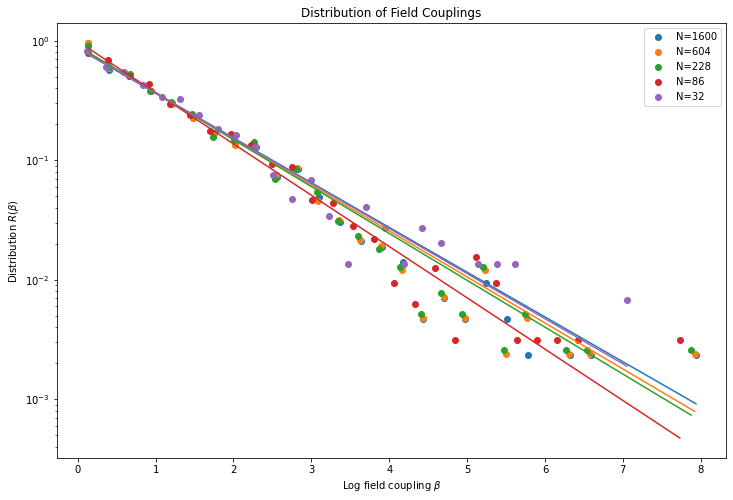

In [489]:
n_bins_h = 30
plt.figure(figsize=(12, 8))
width_list = []
N_list = []
for ind,i in enumerate(check_list[:]):
    n,bins = np.histogram(beta_dist_list[ind], density=True, bins = n_bins_h)
    if np.any(np.isnan(n)): continue
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)
    y = n
    popt, pcov = curve_fit(exponential_dist_norm, x[1:15], y[1:15])
    if ind%2==0: 
        plt.scatter(x, y, label="N="+str(i), marker='o')
        plt.plot(x, exponential_dist_norm(x, *popt))
        #print(popt)
    width_list.append(1/popt[0])
    N_list.append(i)
    
    #plt.scatter((bins[1:]-width/2), n, label="N="+str(i))
#plt.xscale('log')

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
#plt.xlim(0.01, 4)
plt.legend()
#plt.ylim(0.01, 1)

#J_max, h_max = 1.0, 0.5
#L = 60
#a, b = 0.3, 0.315

#plt.xlim(0,6)
#plt.ylim(1e-2, 1)

0.17770407413219333 2.231721095292735


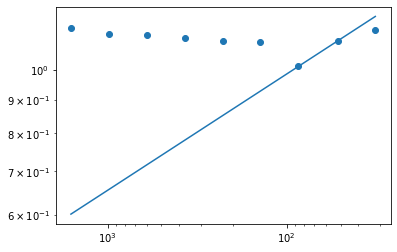

In [490]:
plt.scatter(N_list, width_list)

popt, pcov = curve_fit(power_law_scale, N_list[-3:-1], width_list[-3:-1])
plt.plot(N_list, power_law_scale(N_list, *popt))

plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
print(*popt)

In [283]:
L = 3
a,b,w = 0.1, 0.105, 6


nn_ind = triangle_nn_indices(L)
zeta_ij_vals = fill_zeta_ij_matrix_width(L*L, nn_ind, a, b, w)
beta_vals = np.random.exponential(size=L*L)
test = log_system(L*L, nn_ind, zeta_ij_vals, beta_vals) 

test.adj_ind

{0: [1, 2, 3, 6, 5, 8],
 1: [2, 0, 4, 7, 3, 6],
 2: [0, 1, 5, 8, 4, 7],
 3: [4, 5, 6, 0, 7, 1],
 4: [5, 3, 7, 1, 8, 2],
 5: [3, 4, 8, 2, 6, 0],
 6: [7, 8, 0, 3, 2, 5],
 7: [8, 6, 1, 4, 0, 3],
 8: [6, 7, 2, 5, 1, 4]}

In [344]:
adj_ind = test.adj_ind

Omega_beta = np.min(beta_vals)
print(Omega_beta)
Omega_zeta = np.min(sparse.find(zeta_ij_vals)[2])
print(Omega_zeta)
Omega = min(Omega_beta, Omega_zeta)
print(Omega)

i = np.where(beta_vals==Omega)[0][0]
print(i, adj_ind[i])
ks = adj_ind[i]

zeta_subblock = zeta_ij_vals[np.ix_(ks, ks)].toarray()
old_couplings = sparse.find(zeta_ij_vals[ks,i])[2]
print(old_couplings)
new_couplings = np.add.outer(old_couplings, old_couplings)
np.fill_diagonal(new_couplings, 0)
zeta_subblock[np.where(zeta_subblock==0)]=1000
new_couplings = np.minimum(zeta_subblock, new_couplings)
zeta_ij_vals[np.ix_(ks, ks)] = new_couplings

#Add -log(Omega1/Omega2) = Gamma1 - Gamma2

0.1962420588025167
1.5634708284290164
0.1962420588025167
1 [2, 0, 4, 7, 3, 6]
[4.88703723 5.01186201 2.04499532 5.2383206  5.83909268 4.0809385 ]


/home/guaravtenkila/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


  (0, 1)	-5.0118620074040585
  (0, 2)	-0.19624205880251688
  (0, 3)	-0.19624205880251666
  (0, 4)	-0.19624205880251644
  (0, 5)	-0.19624205880251644
  (0, 6)	-0.19624205880251644
  (0, 7)	-0.19624205880251644
  (0, 8)	-0.19624205880251688
  (1, 0)	-5.0118620074040585
  (1, 2)	-4.887037228801235
  (1, 3)	-5.839092679824728
  (1, 4)	-2.044995316455507
  (1, 6)	-4.080938496719747
  (1, 7)	-5.238320604576758
  (2, 0)	-0.19624205880251688
  (2, 1)	-4.887037228801235
  (2, 3)	-0.19624205880251644
  (2, 4)	-0.19624205880251644
  (2, 5)	-0.19624205880251644
  (2, 6)	-0.19624205880251644
  (2, 7)	-0.19624205880251644
  (2, 8)	-0.19624205880251644
  (3, 0)	-0.19624205880251666
  (3, 1)	-5.839092679824728
  (3, 2)	-0.19624205880251644
  :	:
  (5, 3)	-0.19624205880251644
  (5, 4)	-0.19624205880251688
  (5, 6)	-0.19624205880251644
  (5, 8)	-0.19624205880251688
  (6, 0)	-0.19624205880251644
  (6, 1)	-4.080938496719747
  (6, 2)	-0.19624205880251644
  (6, 3)	-0.19624205880251644
  (6, 4)	-0.1962420588

In [345]:
test.decimate()

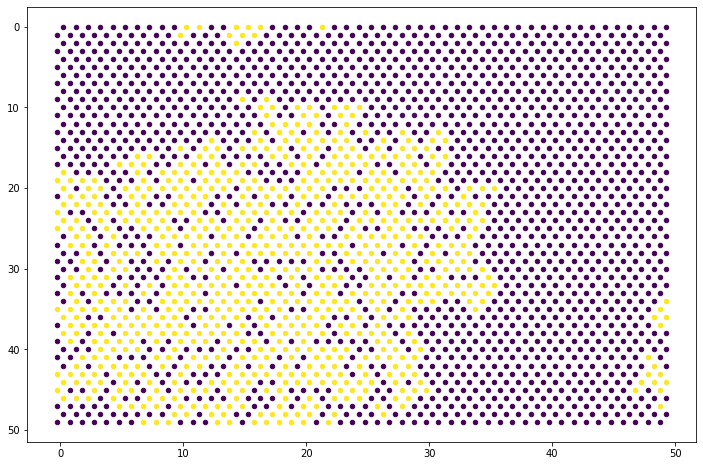

In [205]:
import matplotlib as mpl
import matplotlib.cm as cm
plt.figure(figsize=(12, 8))
clust_dict = test.clust_dict
reverse_dict = test.reverse_dict

norm = mpl.colors.Normalize(vmin=0, vmax=4*L)
cmap = 'viridis'#cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for x in range(L):
    for y in range(L):
        
        site_ind = index_map(x, y, L)
        """
        if clust_dict[site_ind] == site_ind: c='blue'
        else: 
            c = m.cmap(len(reverse_dict[clust_dict[site_ind]]))
        """
        c = m.cmap(len(reverse_dict[clust_dict[site_ind]]))
        plt.scatter(y+(0.25*(-1)**(x%2)), x, color=c, s= 20)
        

plt.gca().invert_yaxis()

In [ ]:
h_vals_remain = h_vals[h_vals!=0]
plt.figure(figsize=(8,5))
n,bins, pacthes = plt.hist(-np.log(h_vals_remain), density=True, bins = 30)

width = bins[1]-bins[0]

plt.figure(figsize=(8,5))
x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.scatter(x_data, n)
plt.title("Distribution of Field Couplings after Decimation")
plt.yscale('log')
plt.legend()
print(popt)

In [ ]:
h_vals_ini = np.exp(-np.random.exponential(size=L*L))
n,bins, pacthes = plt.hist(-np.log(h_vals_ini), density=True, bins = 30)

width = bins[1]-bins[0]


x_data = bins[1:]-width/2
popt, pcov = curve_fit(exponential_dist,x_data, n)

plt.plot(x_data, exponential_dist(x_data, *popt), label='Fit to exponential distribution')
plt.title("Initial Distributions of Field Couplings")
plt.legend()